In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import numpy as np
import skimage.io
import sklearn.cluster
import skimage.segmentation
import pandas
    
    

In [6]:
# Let's start with the paintings

# http://www.touropia.com/most-famous-paintings/
paintings = []

paintings.append(dict(
title='the Birth of Venus',
painter='Sandro Botticelli',
info='https://en.wikipedia.org/wiki/The_Birth_of_Venus',
url='https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Sandro_Botticelli_-_La_nascita_di_Venere_-_Google_Art_Project_-_edited.jpg/1280px-Sandro_Botticelli_-_La_nascita_di_Venere_-_Google_Art_Project_-_edited.jpg'
))
paintings.append(dict(
        title='Le Bassin Aux Nympheas',
        painter='Claude Monet',
        info='https://en.wikipedia.org/wiki/Le_Bassin_Aux_Nymph%C3%A9as',
        url='https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Le_bassin_aux_nymph%C3%A9as_-_Claude_Monet.jpg/1280px-Le_bassin_aux_nymph%C3%A9as_-_Claude_Monet.jpg'
    ))
paintings.append(dict(
        title='de Nachtwacht',
        painter='Rembrandt van Rijn',
        url='https://upload.wikimedia.org/wikipedia/commons/2/28/The_Nightwatch_by_Rembrandt.jpg'
        
    ))
paintings.append(dict(
        title="Skrik",
        painter="Edvard Munch",
        url="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/The_Scream.jpg/804px-The_Scream.jpg"
    ))
paintings.append(dict(
        title="Meisje met de parel",
        painter="Johannes Vermeer",
        url="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Meisje_met_de_parel.jpg/875px-Meisje_met_de_parel.jpg"
    ))
paintings.append(dict(
        title="Guernica ",
        painter="Pablo Picasso",
        url="https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg"
    ))
paintings.append(dict(
        title="Creazione di Adamo",
        painter="Michelangelo di Lodovico Buonarroti Simoni",
        url="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/Creaci%C3%B3n_de_Ad%C3%A1m.jpg/1280px-Creaci%C3%B3n_de_Ad%C3%A1m.jpg"
    ))
paintings.append(dict(
        title="Il cenacolo",
        painter="Leonardo da Vinci",
        url="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/%C3%9Altima_Cena_-_Da_Vinci_5.jpg/1280px-%C3%9Altima_Cena_-_Da_Vinci_5.jpg"
    ))

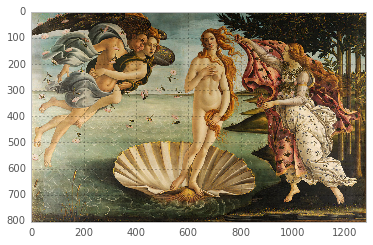

In [7]:
for painting in paintings:
    painting['array'] = skimage.io.imread(painting['url'])
plt.imshow(paintings[0]['array'])

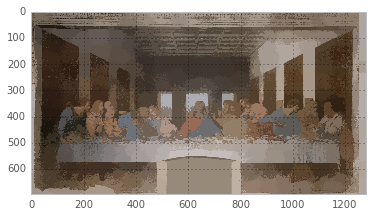

In [8]:
for painting in paintings:
    image = painting['array']
    label = skimage.segmentation.slic(image, n_segments=256, convert2lab=True)
    segmented = skimage.color.label2rgb(label, image, kind='avg')
    plt.imshow(segmented)
    colors = []
    for label_ in range(label.max() + 1):
        color = image[label_ == label][0]
        colors.append(color)
    colors = np.array(colors)
    hsvs = skimage.color.rgb2hsv(colors[:,np.newaxis,:]).squeeze()
    labs = skimage.color.rgb2lab(colors[:,np.newaxis,:]).squeeze()

    clusters = sklearn.cluster.KMeans(n_clusters=15)
    clusters.fit(labs)
    lab_centers = clusters.cluster_centers_
    rgb_centers = skimage.color.luv2rgb(lab_centers[:,np.newaxis,:]).squeeze()
    hsv_centers = skimage.color.rgb2hsv(rgb_centers[:,np.newaxis,:]).squeeze()
    df = pandas.DataFrame(data=dict(h=hsv_centers[:,0], s=hsv_centers[:,1], v=hsv_centers[:,2]))
    sorted_hsv = np.array(df.sort(columns=['v', 'h', 's']))[:,np.newaxis,:]
    sorted_rgb = skimage.color.hsv2rgb(sorted_hsv)
    painting['palette'] = sorted_rgb

In [42]:
def painting2palette(painting, ax=None):
    lab = skimage.color.rgb2lab(painting['array'])
    rgb = skimage.img_as_float(painting['array'])
    rgba = np.dstack([rgb, 0.7*np.ones((rgb.shape[0], rgb.shape[1]), dtype='float32')[:,:,np.newaxis]])
    n = 10000
    sample = np.arange(rgb.shape[0] * rgb.shape[1])
    np.random.shuffle(sample)
    sample = sample[:n]
    colors = rgba.reshape(rgba.shape[0] * rgba.shape[1], rgba.shape[2])[sample, :]

    points = lab.reshape(lab.shape[0] * lab.shape[1], lab.shape[2])[sample, :]
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(points[:,1], points[:,2], c=colors, linewidth=0, edgecolor='none')
    

(0.0, 2.0, 0.0, 8.0)

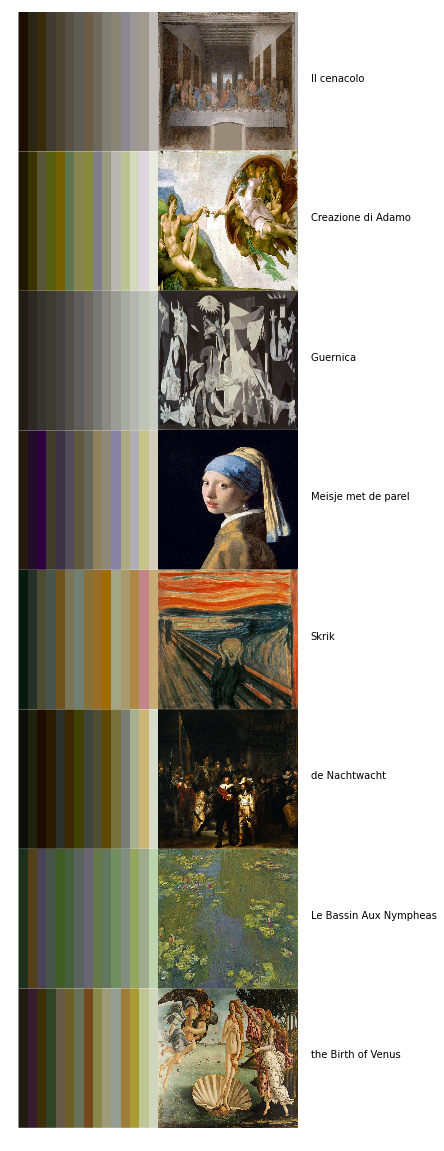

In [9]:
fig, ax = plt.subplots(figsize=(8,20))
for i, painting in enumerate(paintings):
    palette = painting['palette']
    ax.imshow(np.swapaxes(palette, 0, 1), extent=(0, 1, i, i+1), interpolation='none')
    ax.imshow(painting['array'], extent=(1,2,i, i+1))
    ax.text(2.1, i+0.5, painting['title'].encode('ascii'))
ax.autoscale()
ax.axis('off')


In [10]:
pandas

<module 'pandas' from '/Users/baart_f/.virtualenvs/main/lib/python2.7/site-packages/pandas/__init__.pyc'>

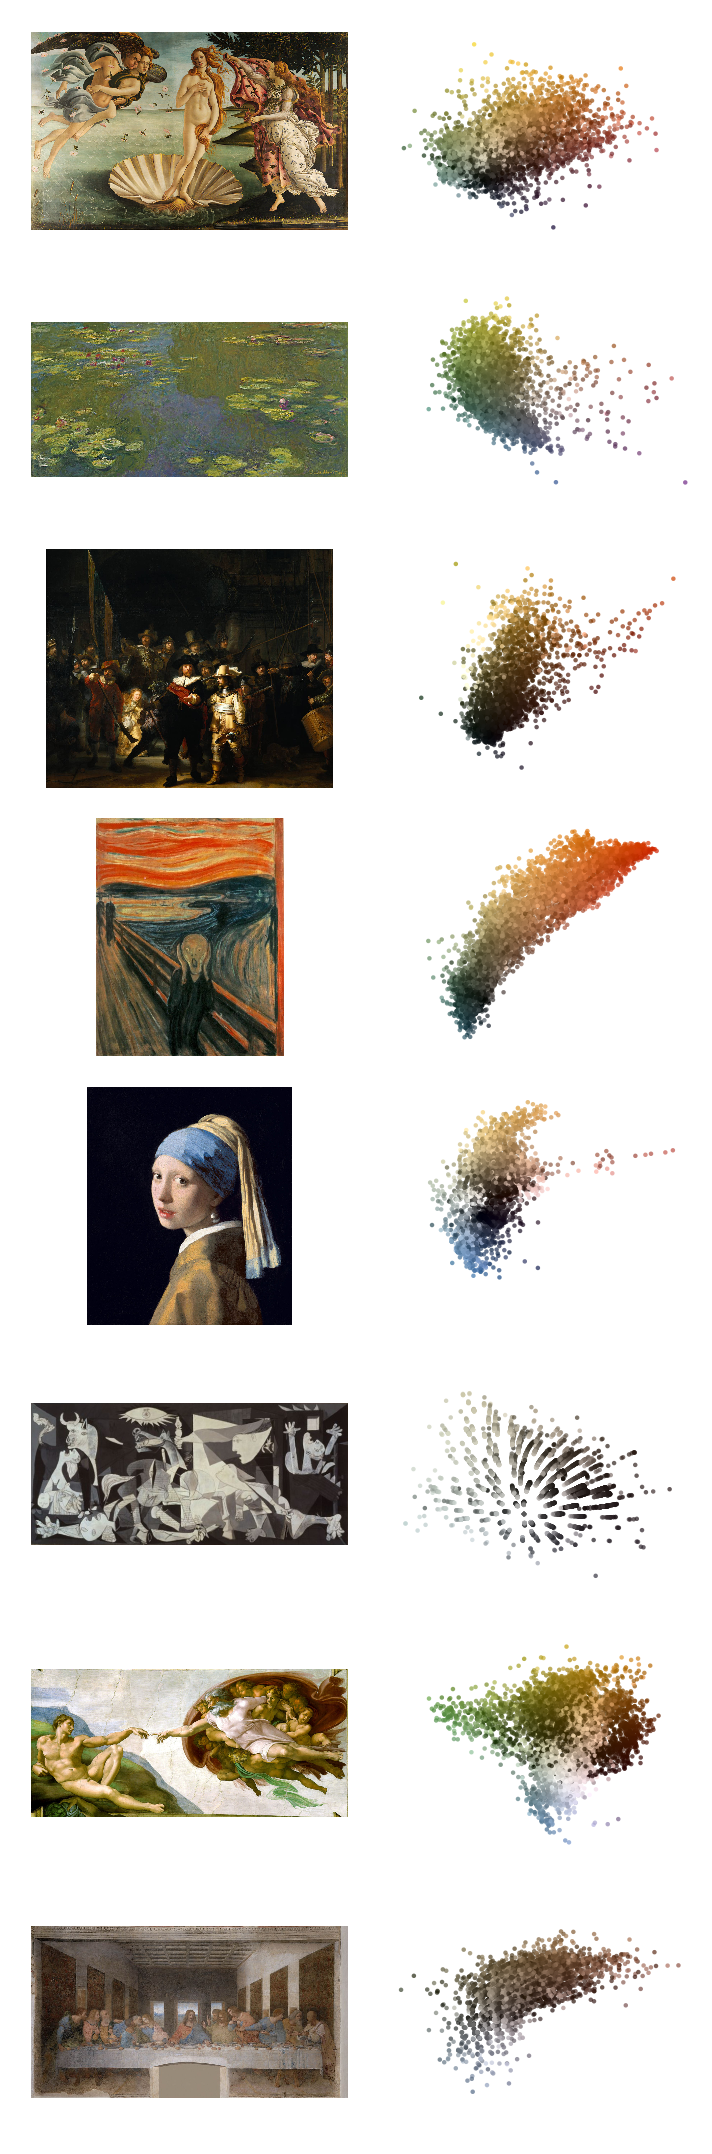

In [50]:
fig, axes = plt.subplots(len(paintings), 2, figsize=(10,30))
for i, (painting, axes_) in enumerate(zip(paintings, axes)):
    palette = painting['palette']
    axes_[0].imshow(painting['array'])
    axes_[0].axis('off')
    painting2palette(painting, ax=axes_[1])
    axes_[1].axis('off')
fig.tight_layout()
fig.savefig('paletteslab.png')